In [2]:
import pandas as pd

def select_state_data(csv_file, state_name):
    """
    Reads a CSV file, filters rows for Massachusetts, 
    and returns a DataFrame containing only Massachusetts data.
    """
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file)

        # Filter rows based on the "state" column
        state_df = df[df["state"] == state_name]
        
        return state_df

    except FileNotFoundError:
        print(f"Error: File '{csv_file}' not found.")
        return None  # Return None in case of an error
    except KeyError:
        print(f"Error: Column 'state' not found in '{csv_file}'.")
        return None

# Usage:
csv_file_path_2020 = "C:/Users/jonas/OneDrive/Dokumente/EPFL École polytéchnique de Lausanne/Cours/MA4/MIT Master Thesis/Work/Power_Outages/eaglei_outages_2020_raw.csv"  # Replace with your CSV file path
massachusetts_df_2020 = select_state_data(csv_file_path_2020, "Massachusetts")

csv_file_path_2021 = "C:/Users/jonas/OneDrive/Dokumente/EPFL École polytéchnique de Lausanne/Cours/MA4/MIT Master Thesis/Work/Power_Outages/eaglei_outages_2021_raw.csv"  # Replace with your CSV file path
massachusetts_df_2021 = select_state_data(csv_file_path_2021, "Massachusetts")

csv_file_path_2022 = "C:/Users/jonas/OneDrive/Dokumente/EPFL École polytéchnique de Lausanne/Cours/MA4/MIT Master Thesis/Work/Power_Outages/eaglei_outages_2022_raw.csv"  # Replace with your CSV file path
massachusetts_df_2022 = select_state_data(csv_file_path_2022, "Massachusetts")

csv_file_path_2023 = "C:/Users/jonas/OneDrive/Dokumente/EPFL École polytéchnique de Lausanne/Cours/MA4/MIT Master Thesis/Work/Power_Outages/eaglei_outages_2023_raw.csv"  # Replace with your CSV file path
massachusetts_df_2023 = select_state_data(csv_file_path_2023, "Massachusetts")




dfs = [massachusetts_df_2020, massachusetts_df_2021, massachusetts_df_2022, massachusetts_df_2023]
years = [2020, 2021, 2022, 2023]

for df, year in zip(dfs, years):
    if df is not None:  # Check if filtering was successful
        unique_counties = df["county"].unique()
        num_unique_counties = len(unique_counties)

        print(f"Unique Counties in Massachusetts for {year}: {num_unique_counties}")
    else:
        print(f"No data available for Massachusetts in {year}")

Unique Counties in Massachusetts for 2020: 14
Unique Counties in Massachusetts for 2021: 14
Unique Counties in Massachusetts for 2022: 14
Unique Counties in Massachusetts for 2023: 14


In [3]:
massachusetts_df_2023.rename(columns={'sum': 'customers_out'}, inplace=True)
# Assuming any of the massachusetts_df_YYYY DataFrames is available (replace YYYY with the actual year)
all_county_names = massachusetts_df_2020['county'].unique()

# Print the list of all county names
print(all_county_names)

['Berkshire' 'Bristol' 'Essex' 'Franklin' 'Hampden' 'Hampshire'
 'Middlesex' 'Norfolk' 'Plymouth' 'Suffolk' 'Worcester' 'Dukes'
 'Barnstable' 'Nantucket']


In [4]:
# determine the overall outage likelihood in 2020 to 2024
#massachusetts_df_2020.to_csv('massachusetts_df_2020.csv', index=False) 
total_customer_outage_minutes_ma_2020 = 15 *massachusetts_df_2020["customers_out"].sum()
total_customer_outage_minutes_ma_2021 = 15 *massachusetts_df_2021["customers_out"].sum()
total_customer_outage_minutes_ma_2022 = 15 *massachusetts_df_2022["customers_out"].sum()
total_customer_outage_minutes_ma_2023 = 15 *massachusetts_df_2023["customers_out"].sum()

number_of_customers_ma_2020 = 2982765.802
number_of_customers_ma_2021 = 3184443.264
number_of_customers_ma_2022 = 3212513.726
number_of_customers_ma_2023 = 3212513.726

outage_minutes_per_customer_ma_2020 = total_customer_outage_minutes_ma_2020/ number_of_customers_ma_2020
outage_minutes_per_customer_ma_2021 = total_customer_outage_minutes_ma_2021/ number_of_customers_ma_2021
outage_minutes_per_customer_ma_2022 = total_customer_outage_minutes_ma_2022/ number_of_customers_ma_2022
outage_minutes_per_customer_ma_2023 = total_customer_outage_minutes_ma_2023/ number_of_customers_ma_2023

overall_outage_likelihood = (outage_minutes_per_customer_ma_2020 + outage_minutes_per_customer_ma_2021 + outage_minutes_per_customer_ma_2022 + outage_minutes_per_customer_ma_2023)/(4*8760*60)
overall_outage_likelihood * 100



np.float64(0.06338075495211075)

Overall Outage Likelihood: 0.0634%
Non outages out of 35040: 22
Outages out of 35040: 35018


NameError: name 'likelihood_percentage_per_year' is not defined

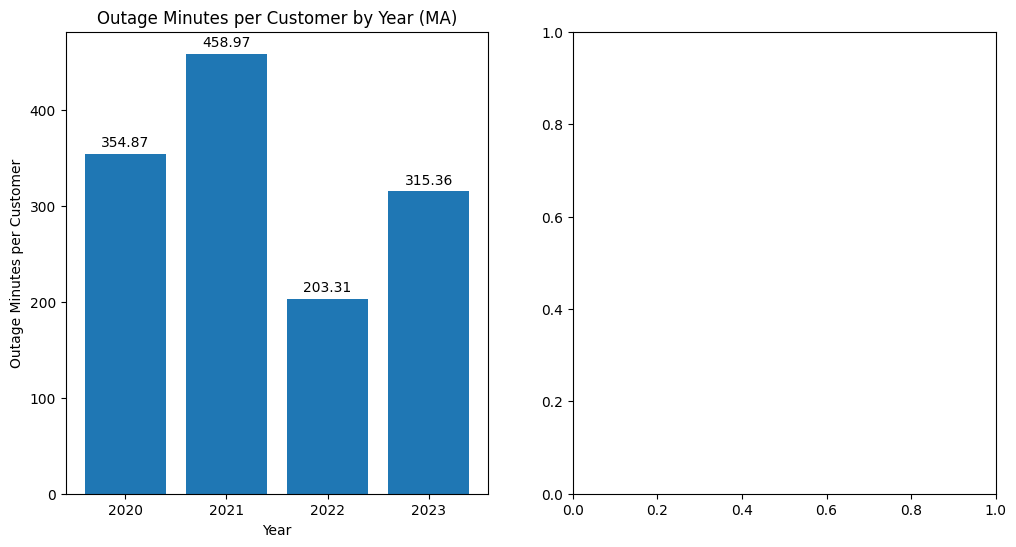

In [5]:
%%script false
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the DataFrames: massachusetts_df_2020, ..., massachusetts_df_2023

# Constants
YEARS = [2020, 2021, 2022, 2023]
CUSTOMER_COUNTS = [2982765.802, 3184443.264, 3212513.726, 3212513.726]

# Calculate outage minutes per customer for each year
outage_minutes_per_customer = {}
for year, customer_count in zip(YEARS, CUSTOMER_COUNTS):
    df = globals()[f'massachusetts_df_{year}']  # Access DataFrame dynamically
    total_outage_minutes = 15 * df["customers_out"].sum()
    outage_minutes_per_customer[year] = total_outage_minutes / customer_count

# Calculate overall outage likelihood
overall_outage_likelihood = sum(outage_minutes_per_customer.values()) / (4 * 8760 * 60)
overall_outage_likelihood_percentage = overall_outage_likelihood * 100

print(f"Overall Outage Likelihood: {overall_outage_likelihood_percentage:.4f}%")
print(f"Non outages out of 35040: {round(overall_outage_likelihood*35040)}")
print(f"Outages out of 35040: {round((1-overall_outage_likelihood)*35040)}")

# Create subplots for side-by-side arrangement
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Outage Minutes per Customer (with values on top)
bars1 = axes[0].bar(outage_minutes_per_customer.keys(), outage_minutes_per_customer.values())
axes[0].set_xticks(YEARS)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Outage Minutes per Customer")
axes[0].set_title("Outage Minutes per Customer by Year (MA)")

# Add values on top of bars in Plot 1
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{height:.2f}', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom') 


# Plot 2: Outage Likelihood (in percentage, with values on top)
bars2 = axes[1].bar(likelihood_percentage_per_year.keys(), likelihood_percentage_per_year.values())
axes[1].set_xticks(YEARS)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Outage Likelihood (%)")
axes[1].set_title("Outage Likelihood per Year (MA)")

# Add values on top of bars in Plot 2
for bar in bars2:
    height = bar.get_height()
    axes[1].annotate(f'{height:.2f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom') 


plt.tight_layout()
plt.show()

In [6]:
county_names = ["Franklin","Suffolk", "Middlesex", "Barnstable", "Berkshire", "Bristol", "Essex", "Hampden", "Hampshire", "Norfolk", "Plymouth", "Worcester", "Dukes", "Nantucket"] 

# Loop through each county name and create DataFrames for each year
for county_name in county_names:
  # Filter for the current county
  county_df_2020 = massachusetts_df_2020[massachusetts_df_2020["county"] == county_name]
  county_df_2021 = massachusetts_df_2021[massachusetts_df_2021["county"] == county_name]
  county_df_2022 = massachusetts_df_2022[massachusetts_df_2022["county"] == county_name]
  county_df_2023 = massachusetts_df_2023[massachusetts_df_2023["county"] == county_name]

  # Dynamically create DataFrame names and assign the filtered DataFrames
  globals()[f"{county_name}_df_2020"] = county_df_2020
  globals()[f"{county_name}_df_2021"] = county_df_2021
  globals()[f"{county_name}_df_2022"] = county_df_2022
  globals()[f"{county_name}_df_2023"] = county_df_2023

    # List of DataFrames to concatenate for the current county
  dataframes_to_concat = [
      globals()[f"{county_name}_df_2020"],
      globals()[f"{county_name}_df_2021"],
      globals()[f"{county_name}_df_2022"],
      globals()[f"{county_name}_df_2023"]
  ]

  # Concatenate the DataFrames for the current county
  globals()[f"{county_name}_df"] = pd.concat(dataframes_to_concat, ignore_index=True)




In [7]:
import pandas as pd

def get_season(date):
    month = date.month
    day = date.day

    if (month == 3 and day >= 1) or (month >= 4 and month <= 5) or (month == 6 and day == 1):
        return 2  # Spring
    elif month >= 6 and month <= 8:
        return 1  # Summer
    elif month >= 9 and month <= 11:
        return 2  # Fall
    else:
        return 3  # Winter

# Loop through each county name to process the data
for county_name in county_names:
  # Get the concatenated DataFrame for the current county
  county_df = globals()[f"{county_name}_df"]

  # Enrich with information about weekend/weekday
  county_df['run_start_time'] = pd.to_datetime(county_df['run_start_time'])
  county_df = county_df.sort_values('run_start_time')
  county_df['Weekend'] = county_df['run_start_time'].dt.weekday.isin([5, 6]).astype(int)

  # Apply the get_season function to create the 'Season' column
  county_df['Season'] = county_df['run_start_time'].apply(get_season)

  # Extract month and hour information
  county_df['month'] = county_df['run_start_time'].dt.month
  county_df['hour'] = county_df['run_start_time'].dt.hour

  # Update the concatenated DataFrame for the current county
  globals()[f"{county_name}_df"] = county_df




In [8]:
import pandas as pd

# ... (previous code to create county-specific DataFrames and add Weekend/Season columns) ...

# Loop through each county name to process the data
for county_name in county_names:
  # Get the concatenated DataFrame for the current county
  county_df = globals()[f"{county_name}_df"]

  # Sort by 'run_start_time' to ensure chronological order
  county_df = county_df.sort_values('run_start_time')

  # Calculate the time difference between consecutive rows in minutes
  county_df['time_diff'] = county_df['run_start_time'].diff().dt.total_seconds() / 60

  # Fill the first difference (which will be NaN) with 15 (assuming the first row is the start of an outage)
  county_df['time_diff'].fillna(15, inplace=True)

  # Create an 'outage_id' column to group consecutive 15-minute intervals into outages
  county_df['outage_id'] = (county_df['time_diff'] > 15).cumsum()

  # Create a boolean mask to identify the first row of each outage group
  is_start_of_outage = county_df['outage_id'] != county_df['outage_id'].shift(1)

  # Filter the DataFrame using the mask to get only the starting times
  globals()[f"{county_name}_starting_df"] = county_df[is_start_of_outage].copy()

  # Update the concatenated DataFrame for the current county
  globals()[f"{county_name}_df"] = county_df

# Get the concatenated DataFrame and the starting DataFrame for the current county
  county_df = globals()[f"{county_name}_df"]
  county_starting_df = globals()[f"{county_name}_starting_df"] 

  # Group by 'outage_id' and count the number of intervals to get the outage duration in intervals
  outage_durations_df = county_df.groupby('outage_id').size().reset_index(name='duration_intervals')

  # Convert duration from intervals to minutes
  outage_durations_df['duration_minutes'] = outage_durations_df['duration_intervals'] * 15

  # Merge the two DataFrames on 'outage_id'
  county_starting_df = pd.merge(county_starting_df, outage_durations_df, on='outage_id', how='left')
  county_starting_df.drop(columns=['time_diff'], inplace=True)

  # Update the starting DataFrame for the current county
  globals()[f"{county_name}_starting_df"] = county_starting_df

C:\Users\jonas\AppData\Local\Temp\ipykernel_25516\2439399215.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  county_df['time_diff'].fillna(15, inplace=True)
C:\Users\jonas\AppData\Local\Temp\ipykernel_25516\2439399215.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [75]:
# Just for control, and it works!

# Count outages longer than 480 minutes
longer_than_480 = Middlesex_starting_df[Middlesex_starting_df['duration_minutes'] >= 60].shape[0]

# Count outages shorter than or equal to 480 minutes
shorter_than_or_equal_to_480 = Middlesex_starting_df[Middlesex_starting_df['duration_minutes'] >= 480].shape[0]

print("Number of outages longer than 60 minutes:", longer_than_480)
print("Number of outages longer than 480 minutes:", shorter_than_or_equal_to_480)

Number of outages longer than 60 minutes: 3031
Number of outages longer than 480 minutes: 950


In [76]:
# Collect all the county-specific starting DataFrames
starting_dfs = [globals()[f"{county_name}_starting_df"] for county_name in county_names]

# Concatenate all the starting DataFrames into a single DataFrame
Massachusetts_starting_df = pd.concat(starting_dfs, ignore_index=True)
Massachusetts_starting_df.head()

,fips_code,county,state,customers_out,run_start_time,Weekend,Season,month,hour,outage_id,duration_intervals,duration_minutes,duration_category
0,25011,Franklin,Massachusetts,10.0,2020-01-01 00:00:00,0,3,1,0,0,32,480,361-1440min
1,25011,Franklin,Massachusetts,2.0,2020-01-01 16:30:00,0,3,1,16,1,5,75,61-180min
2,25011,Franklin,Massachusetts,19.0,2020-01-01 19:00:00,0,3,1,19,2,36,540,361-1440min
3,25011,Franklin,Massachusetts,1.0,2020-01-02 08:00:00,0,3,1,8,3,1,15,0-60min
4,25011,Franklin,Massachusetts,20.0,2020-01-03 15:30:00,0,3,1,15,4,2,30,0-60min


In [80]:
import pandas as pd

# Calculate the threshold for the 0.1% longest outages
threshold = int(0.001 * len(Massachusetts_starting_df))

# Sort by duration in descending order
df_sorted = Massachusetts_starting_df.sort_values(by='duration_minutes', ascending=False)

# Select and display the top rows (0.1% longest)
top_outages = df_sorted.head(threshold)

if top_outages.empty:
    print("No outages found within the top 0.1%.")
else:
    print("\nTop 0.1% Longest Outages in Massachusetts:\n")
    print(top_outages)




Top 0.1% Longest Outages in Massachusetts:

       fips_code      county          state  customers_out  \
32655      25013     Hampden  Massachusetts           16.0   
32657      25013     Hampden  Massachusetts           29.0   
32594      25013     Hampden  Massachusetts           12.0   
32789      25013     Hampden  Massachusetts            1.0   
32790      25013     Hampden  Massachusetts           13.0   
32774      25013     Hampden  Massachusetts           14.0   
32589      25013     Hampden  Massachusetts            1.0   
32598      25013     Hampden  Massachusetts         1676.0   
32670      25013     Hampden  Massachusetts           11.0   
32654      25013     Hampden  Massachusetts            1.0   
32587      25013     Hampden  Massachusetts           16.0   
32799      25013     Hampden  Massachusetts           12.0   
32676      25013     Hampden  Massachusetts         1231.0   
32658      25013     Hampden  Massachusetts            5.0   
32666      25013     Hamp

In [12]:
# Get the list of outage_id from top_outages DataFrame
outage_ids_to_remove = top_outages['outage_id'].tolist()
# Print the shape of the filtered DataFrame to verify the removal
print(f"\nShape of the original DataFrame: {Massachusetts_starting_df.shape}")

# Filter the Massachusetts_starting_df DataFrame
Massachusetts_starting_df = Massachusetts_starting_df[~Massachusetts_starting_df['outage_id'].isin(outage_ids_to_remove)]

print(f"Shape of the filtered DataFrame: {Massachusetts_starting_df.shape}")
Massachusetts_starting_df["customers_out"].sum()


Shape of the original DataFrame: (54338, 12)
Shape of the filtered DataFrame: (54026, 12)


np.float64(2488307.0)

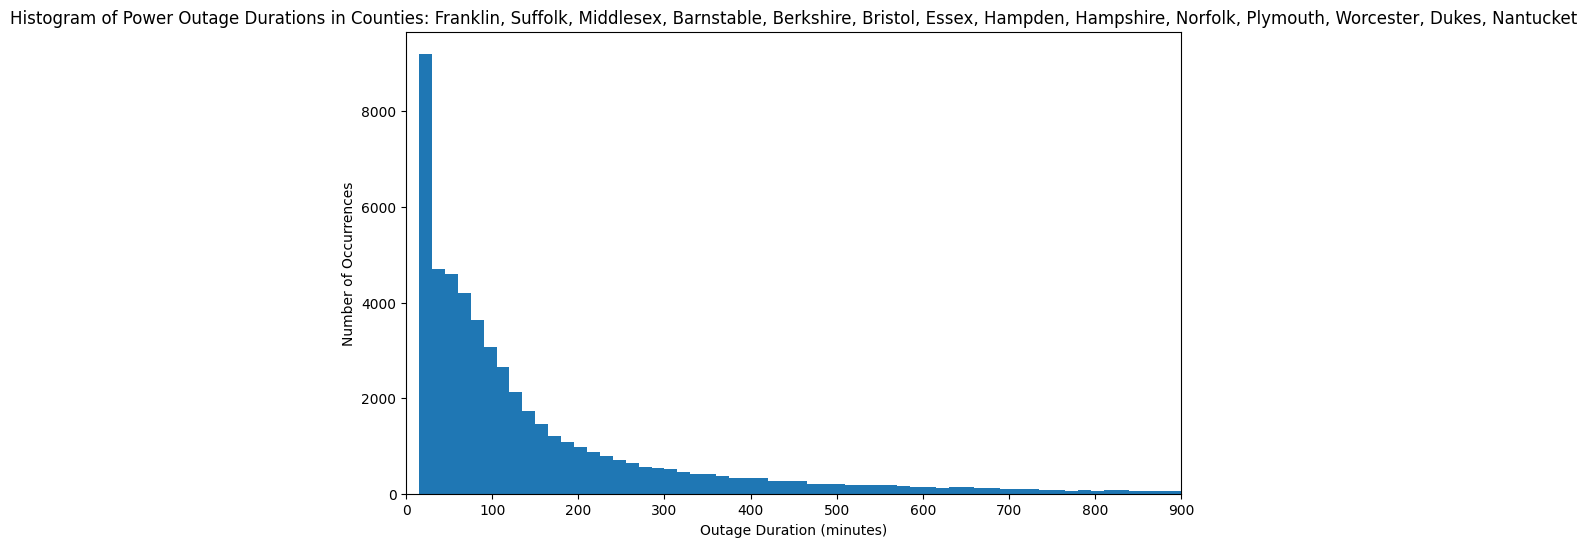

In [13]:
# Plot the histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) 
plt.xlim(0, 900)
plt.hist(Massachusetts_starting_df['duration_minutes'], bins = list(range(0, 15000, 15)))  # Adjust 'bins' as needed
plt.xlabel('Outage Duration (minutes)')
plt.ylabel('Number of Occurrences')
plt.title(f'Histogram of Power Outage Durations in Counties: {", ".join(county_names)}')
plt.show()

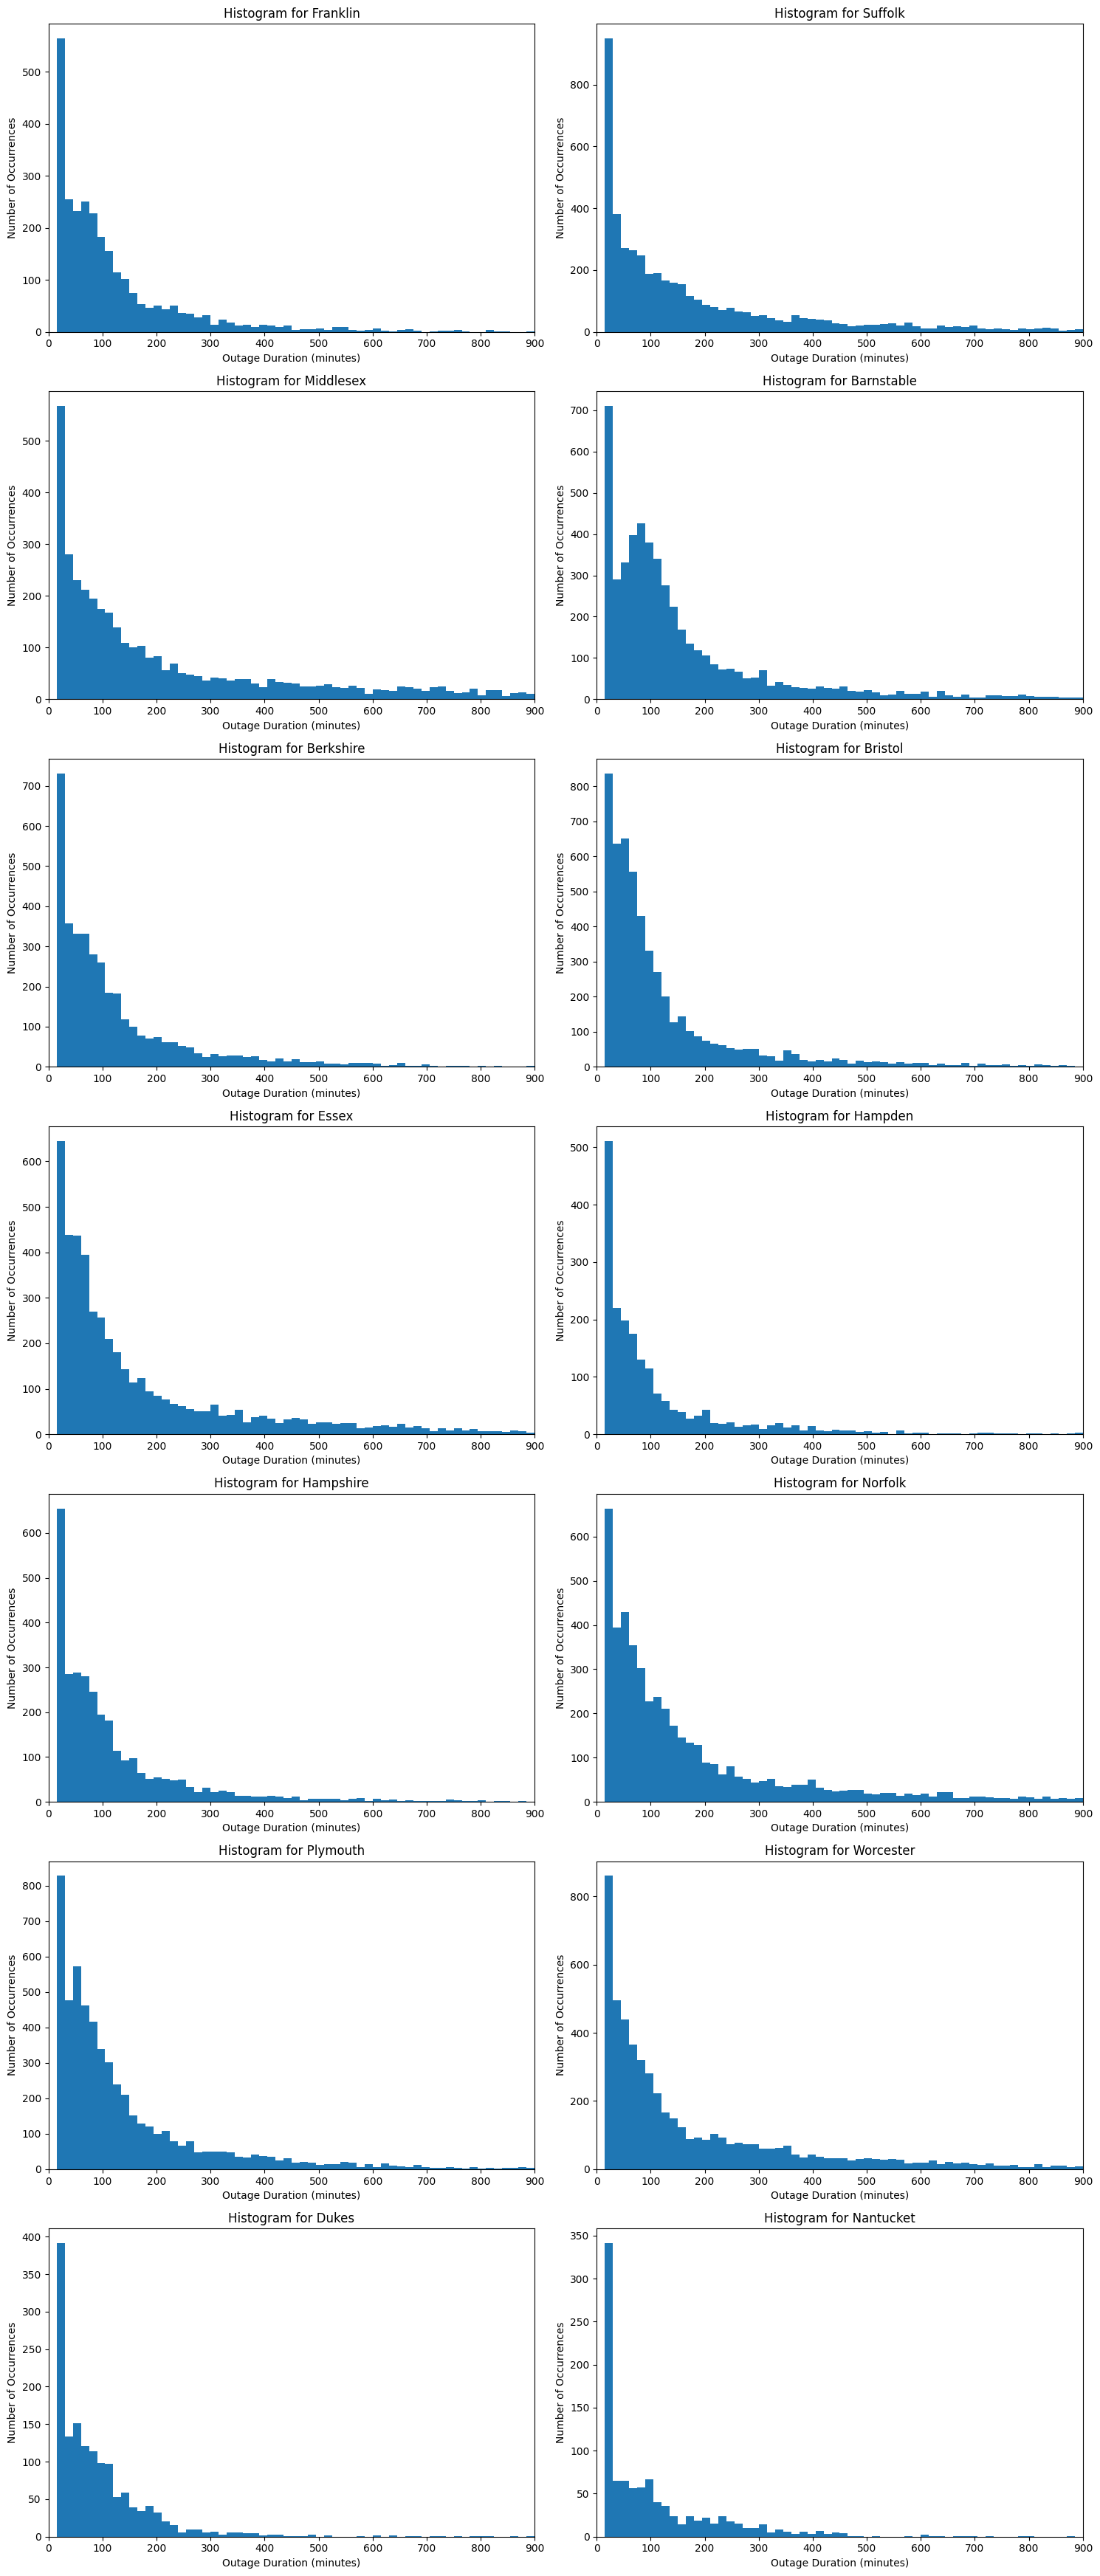

In [14]:
import matplotlib.pyplot as plt

# ... (your existing code to create county_specific DataFrames and Massachusetts_starting_df) ...

# Calculate number of rows and columns for subplots
num_counties = len(county_names)
num_cols = 2  # Adjust this if you want more columns
num_rows = (num_counties + num_cols - 1) // num_cols  # Calculate rows needed

# Create subplots with adjusted figsize
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))  # Adjust figsize as needed

# Flatten axes array if only one row
if num_rows == 1:
    axes = axes.flatten()

# Iterate through county names and plot histograms
for i, county_name in enumerate(county_names):
    county_starting_df = globals()[f"{county_name}_starting_df"]

    # Calculate row and column index for current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Plot on the correct subplot
    axes[row_idx, col_idx].hist(county_starting_df['duration_minutes'], bins=list(range(0, 15000, 15)))
    axes[row_idx, col_idx].set_xlabel('Outage Duration (minutes)')
    axes[row_idx, col_idx].set_ylabel('Number of Occurrences')
    axes[row_idx, col_idx].set_title(f'Histogram for {county_name}')
    axes[row_idx, col_idx].set_xlim(0, 900)

# Hide any empty subplots if the number of counties is not a multiple of num_cols
for i in range(num_counties, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd

# Define bins and labels (same as before)
bins = [0, 61, 181, 361, 1441, float('inf')]
labels = ['0-60min', '61-180min', '181-360min', '361-1440min', '>1440min']

# Iterate through county names and process each
for county_name in county_names:
    county_starting_df = globals()[f"{county_name}_starting_df"]

    # Create 'duration_category' column
    county_starting_df['duration_category'] = pd.cut(county_starting_df['duration_minutes'], bins=bins, labels=labels, right=False)

    # Count occurrences and calculate percentages
    category_counts = county_starting_df['duration_category'].value_counts()
    total_count = len(county_starting_df)
    category_frequency = (category_counts / total_count) * 100

    # Ensure consistent category order
    category_order = ['0-60min', '61-180min', '181-360min', '361-1440min', '>1440min']
    category_frequency = category_frequency.reindex(category_order)

    # Display results for the current county
    print(f"\nFrequency of Power Outage Durations in {county_name} County:\n")
    print(category_frequency.to_string(float_format='{:.2f}%'.format))


Frequency of Power Outage Durations in Franklin County:

duration_category
0-60min       46.61%
61-180min     34.32%
181-360min    12.68%
361-1440min    5.73%
>1440min       0.64%

Frequency of Power Outage Durations in Suffolk County:

duration_category
0-60min       38.89%
61-180min     27.66%
181-360min    15.01%
361-1440min   16.78%
>1440min       1.67%

Frequency of Power Outage Durations in Middlesex County:

duration_category
0-60min       31.38%
61-180min     26.05%
181-360min    14.24%
361-1440min   23.81%
>1440min       4.53%

Frequency of Power Outage Durations in Barnstable County:

duration_category
0-60min       33.92%
61-180min     40.59%
181-360min    14.03%
361-1440min   10.87%
>1440min       0.59%

Frequency of Power Outage Durations in Berkshire County:

duration_category
0-60min       45.74%
61-180min     33.25%
181-360min    12.96%
361-1440min    7.45%
>1440min       0.60%

Frequency of Power Outage Durations in Bristol County:

duration_category
0-60min       50.

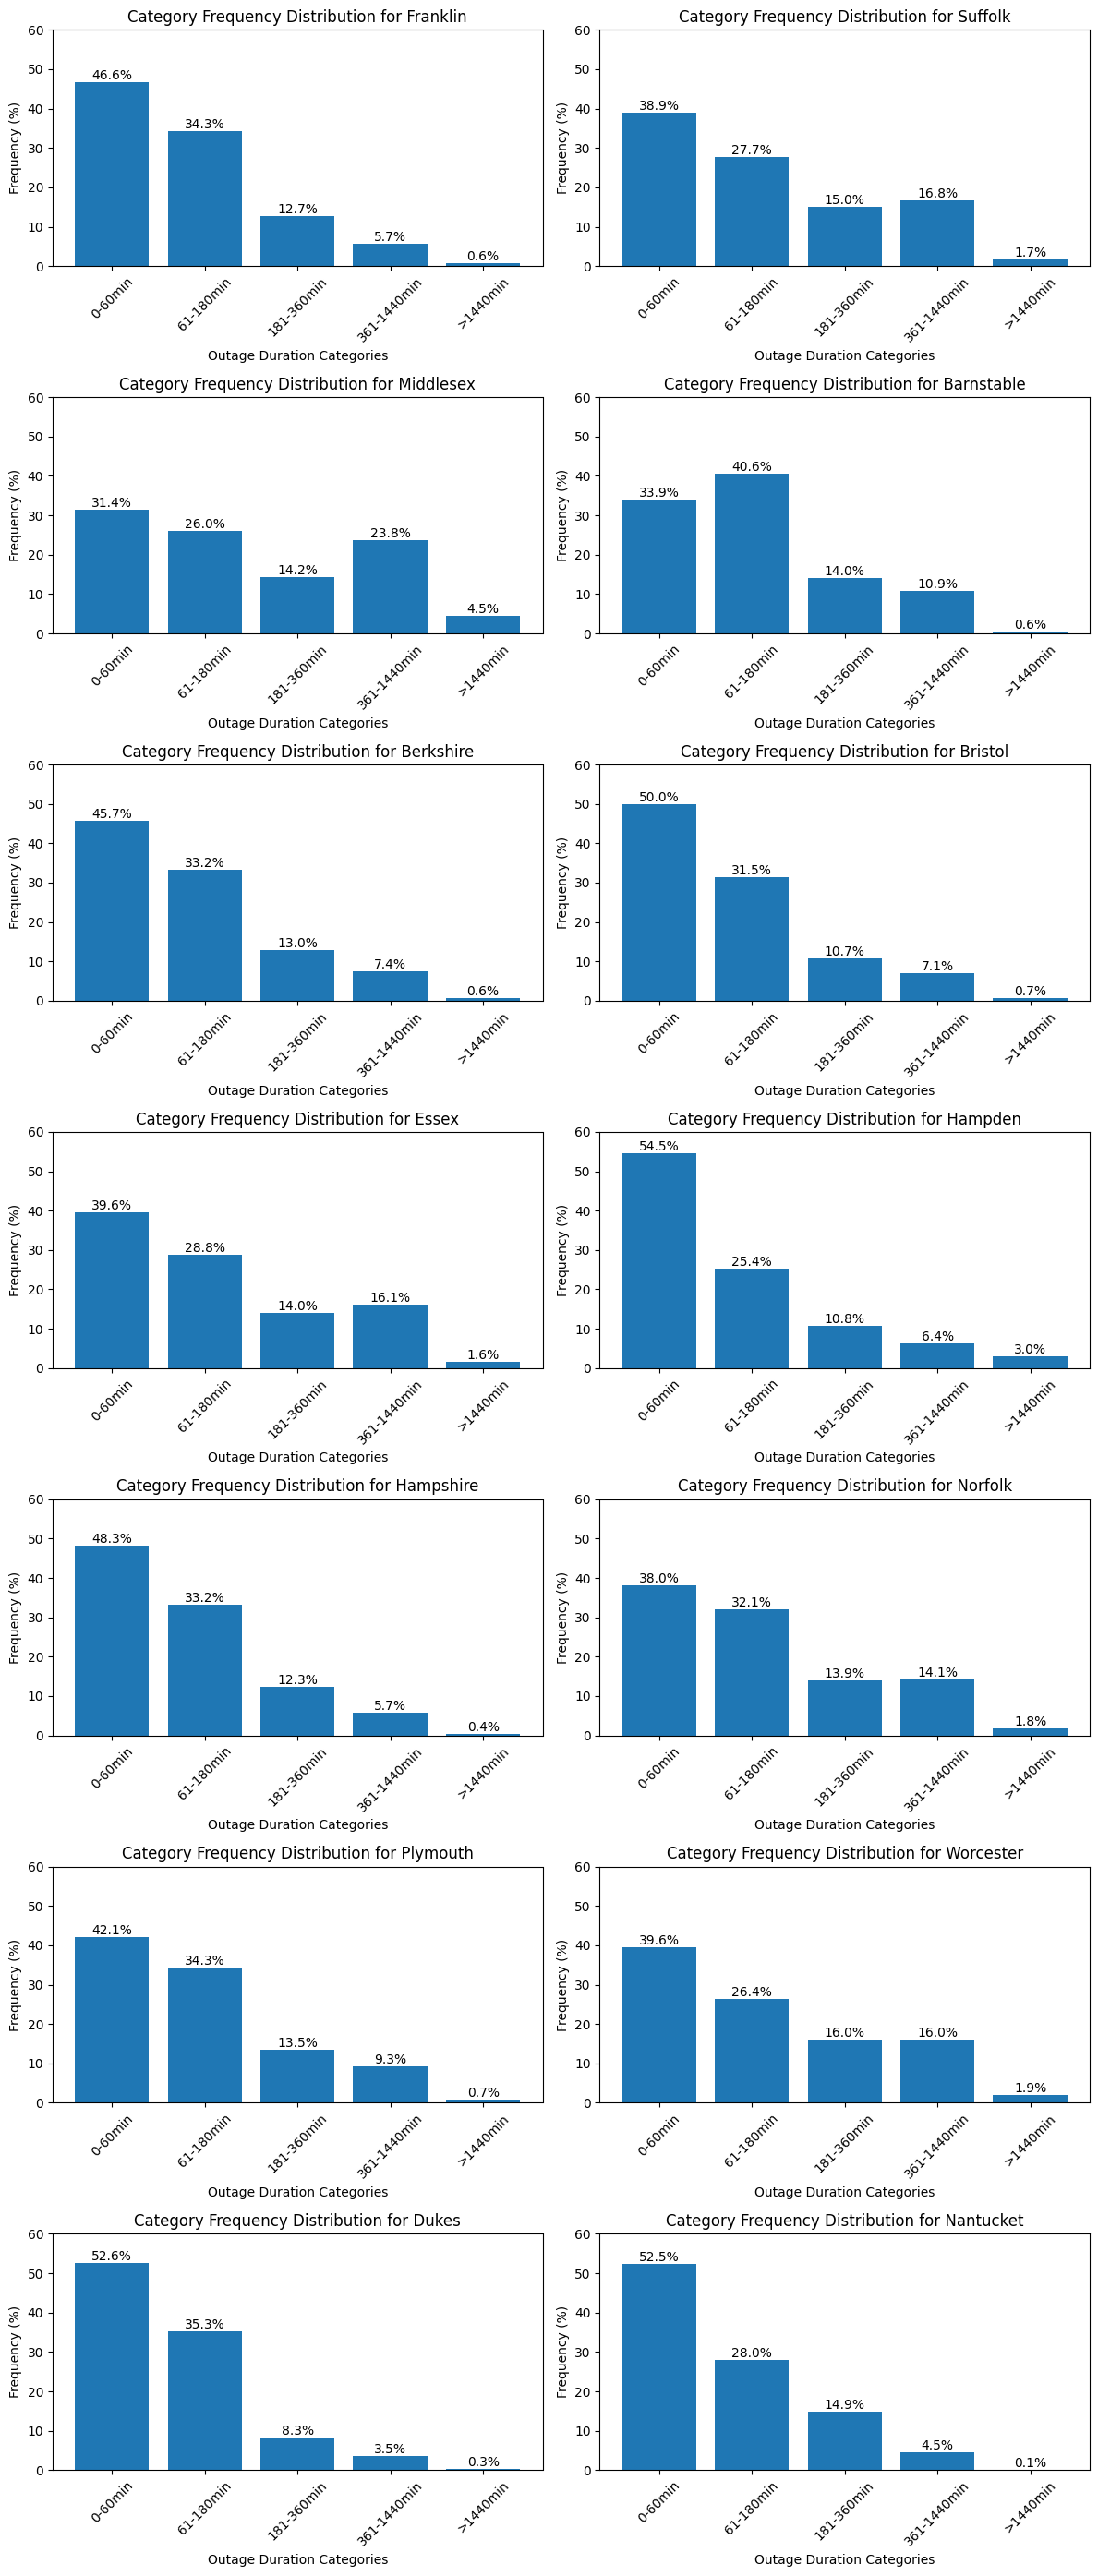

In [16]:
import matplotlib.pyplot as plt

# ... (your existing code to create county_specific DataFrames and Massachusetts_starting_df) ...

# Define bins and labels
bins = [0, 61, 181, 361, 1441, float('inf')]
labels = ['0-60min', '61-180min', '181-360min', '361-1440min', '>1440min']

# Calculate the number of rows and columns for the subplots
num_counties = len(county_names)
num_cols = 2  # You can adjust this to have more columns if needed
num_rows = (num_counties + num_cols - 1) // num_cols 

# Create the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 4*num_rows)) 

# Flatten the axes array if there's only one row
if num_rows == 1:
    axes = axes.flatten()

# Iterate through county names and plot bar charts
for i, county_name in enumerate(county_names):
    county_starting_df = globals()[f"{county_name}_starting_df"]

    # Create 'duration_category' column
    county_starting_df['duration_category'] = pd.cut(county_starting_df['duration_minutes'], bins=bins, labels=labels, right=False)

    # Count and calculate percentages
    category_counts = county_starting_df['duration_category'].value_counts()
    total_count = len(county_starting_df)
    category_frequency = (category_counts / total_count) * 100

    # Ensure consistent category order
    category_order = ['0-60min', '61-180min', '181-360min', '361-1440min', '>1440min']
    category_frequency = category_frequency.reindex(category_order)

    # Calculate row and column index for the current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Create the bar chart on the specified subplot
    bars = axes[row_idx, col_idx].bar(labels, category_frequency)

    # Add percentage labels
    for bar in bars:
        yval = bar.get_height()
        axes[row_idx, col_idx].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')

    # Set labels and title
    axes[row_idx, col_idx].set_xlabel('Outage Duration Categories')
    axes[row_idx, col_idx].set_ylabel('Frequency (%)')
    axes[row_idx, col_idx].set_title(f'Category Frequency Distribution for {county_name}')
    axes[row_idx, col_idx].set_ylim(0, 60)
    axes[row_idx, col_idx].set_xticks(labels)
    axes[row_idx, col_idx].tick_params(axis='x', rotation=45)

# Hide any empty subplots if the number of counties is not a multiple of num_cols
for i in range(num_counties, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [17]:
Massachusetts_starting_df.tail(500)

,fips_code,county,state,customers_out,run_start_time,Weekend,Season,month,hour,outage_id,duration_intervals,duration_minutes
53837,25019,Nantucket,Massachusetts,65.0,2022-02-09 16:45:00,0,3,2,16,503,7,105
53838,25019,Nantucket,Massachusetts,1.0,2022-02-12 19:15:00,1,3,2,19,504,6,90
53839,25019,Nantucket,Massachusetts,1.0,2022-02-14 15:30:00,0,3,2,15,505,17,255
53840,25019,Nantucket,Massachusetts,1.0,2022-02-17 12:45:00,0,3,2,12,506,8,120
53841,25019,Nantucket,Massachusetts,1.0,2022-02-19 19:00:00,1,3,2,19,507,2,30
...,...,...,...,...,...,...,...,...,...,...,...,...
54333,25019,Nantucket,Massachusetts,1.0,2023-12-21 17:15:00,0,3,12,17,999,5,75
54334,25019,Nantucket,Massachusetts,1.0,2023-12-26 23:30:00,0,3,12,23,1000,5,75
54335,25019,Nantucket,Massachusetts,1.0,2023-12-27 19:15:00,0,3,12,19,1001,11,165
54336,25019,Nantucket,Massachusetts,1.0,2023-12-31 05:00:00,1,3,12,5,1002,4,60


In [18]:
import pandas as pd

# Select the relevant columns for the correlation analysis
columns_to_analyze = ['hour', 'month', 'duration_minutes', 'Weekend', 'Season', 'customers_out']
subset_df = Massachusetts_starting_df[columns_to_analyze]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Print the correlation matrix
print(correlation_matrix)

                      hour     month  duration_minutes   Weekend    Season  \
hour              1.000000 -0.022581         -0.018484 -0.017241  0.029149   
month            -0.022581  1.000000          0.015121  0.008747 -0.209139   
duration_minutes -0.018484  0.015121          1.000000 -0.027588 -0.047657   
Weekend          -0.017241  0.008747         -0.027588  1.000000 -0.000993   
Season            0.029149 -0.209139         -0.047657 -0.000993  1.000000   
customers_out    -0.013677  0.002574          0.040806  0.003039  0.000521   

                  customers_out  
hour                  -0.013677  
month                  0.002574  
duration_minutes       0.040806  
Weekend                0.003039  
Season                 0.000521  
customers_out          1.000000  


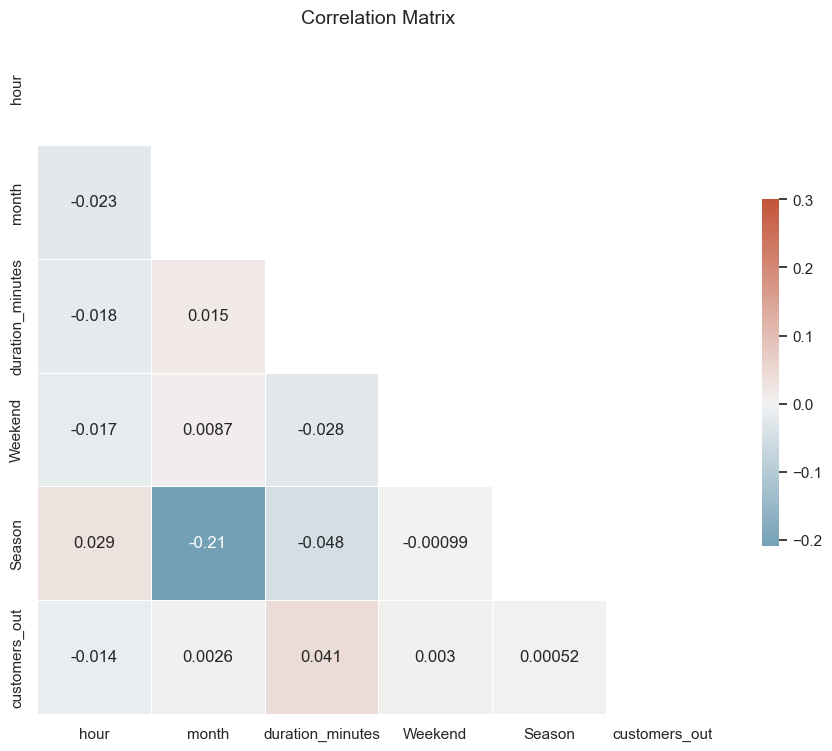

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the aesthetic style of the plots
sns.set_theme(style="white")

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Generate a mask for the upper triangle (to avoid redundant information)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlation Matrix', fontsize=14)
plt.show()

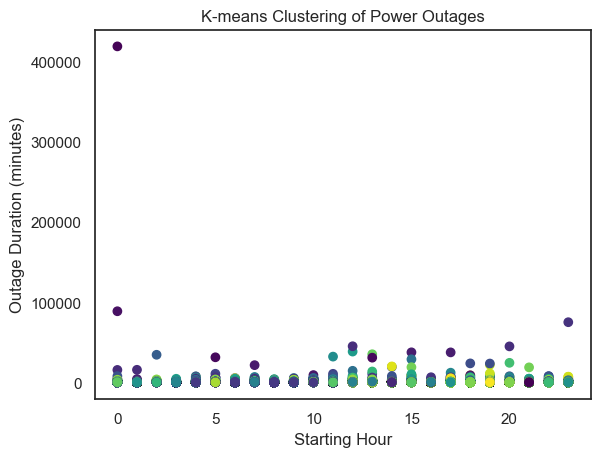

In [81]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select the columns you want to use for clustering (replace with your actual column names)
clustering_columns = ['hour', 'duration_minutes']  # Example

# Create a new DataFrame with only the selected columns
X = Massachusetts_starting_df[clustering_columns]

# Choose the number of clusters (k) - you might need to experiment to find the optimal value
k = 100  # Example

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)  # Set random_state for reproducibility

# Fit the model to your data
kmeans.fit(X)

# Get the cluster labels for each data point
Massachusetts_starting_df['cluster'] = kmeans.labels_

# Visualize the clusters (optional)
plt.scatter(X['hour'], X['duration_minutes'], c=Massachusetts_starting_df['cluster'], cmap='viridis')
plt.xlabel('Starting Hour')
plt.ylabel('Outage Duration (minutes)')
plt.title('K-means Clustering of Power Outages')
plt.show()

In [21]:
# Add cluster labels to the X DataFrame
X['cluster'] = kmeans.labels_

# Group by 'cluster' and calculate statistics
cluster_stats = X.groupby('cluster')[['hour', 'duration_minutes']].agg(['mean', 'median', 'count'])
# Calculate the total number of points
total_count = cluster_stats['hour']['count'].sum()

# Calculate the percentage for each cluster
cluster_stats['percentage'] = ((cluster_stats['hour']['count'] / total_count) * 100).round(2)

# Round the mean and median values to 2 decimal places
cluster_stats = cluster_stats.round(2)

# Display the cluster statistics
print(cluster_stats)

          hour               duration_minutes                 percentage
          mean median  count             mean   median  count           
cluster                                                                 
0        12.85   14.0  18504            26.27     30.0  18504      34.25
1        12.08   12.0    180          2388.33   2370.0    180       0.33
2        11.49   12.0    943           952.41    945.0    943       1.75
3        12.81   12.5     36          5804.58   5625.0     36       0.07
4        12.72   13.0   3166           452.44    450.0   3166       5.86
5        13.51   14.0   8103           172.19    165.0   8103      15.00
6        12.28   11.0     57          4313.16   4260.0     57       0.11
7        14.14   15.0      7         10752.86  10695.0      7       0.01
8        12.63   13.0   1833           671.63    660.0   1833       3.39
9        11.77   12.0    526          1300.81   1290.0    526       0.97
10       13.27   14.0  15682            85.09     9

C:\Users\jonas\AppData\Local\Temp\ipykernel_25516\4120631827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = kmeans.labels_


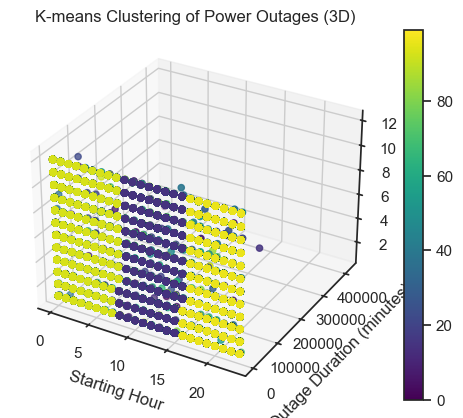

In [82]:
#3D clustering

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# Select the columns for clustering
clustering_columns = ['hour', 'duration_minutes', 'month']

# Create a new DataFrame with only the selected columns
X = Massachusetts_starting_df[clustering_columns]

# Choose the number of clusters (k)
k = 100

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to your data
kmeans.fit(X)

# Get the cluster labels
Massachusetts_starting_df['cluster'] = kmeans.labels_

# 3D Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors based on cluster labels
scatter = ax.scatter(X['hour'], X['duration_minutes'], X['month'], c=Massachusetts_starting_df['cluster'], cmap='viridis')

# Set labels and title
ax.set_xlabel('Starting Hour')
ax.set_ylabel('Outage Duration (minutes)')
ax.set_zlabel('Month')
ax.set_title('K-means Clustering of Power Outages (3D)')

# Add a colorbar
plt.colorbar(scatter)

# Show the plot
plt.show()

In [83]:
# Add cluster labels to the X DataFrame
X['cluster'] = kmeans.labels_

# Group by 'cluster' and calculate statistics, including 'month'
cluster_stats = X.groupby('cluster')[['hour', 'duration_minutes', 'month']].agg(['mean', 'median', 'count'])

# Calculate the total number of points
total_count = cluster_stats['hour']['count'].sum()

# Calculate the percentage for each cluster
cluster_stats['percentage'] = ((cluster_stats['hour']['count'] / total_count) * 100).round(2)

# Round the mean and median values to 2 decimal places
cluster_stats = cluster_stats.round(2)

# Display the cluster statistics
print(cluster_stats)

          hour              duration_minutes                  month         \
          mean median count             mean    median count   mean median   
cluster                                                                      
0        15.69   16.0  2553            90.00      90.0  2553   6.37    6.0   
1         0.00    0.0     1        418995.00  418995.0     1   1.00    1.0   
2        13.00   13.0     1         30825.00   30825.0     1   3.00    3.0   
3        12.73   12.5    48          2288.12    2280.0    48   6.60    7.0   
4         0.00    0.0     1         88710.00   88710.0     1  10.00   10.0   
...        ...    ...   ...              ...       ...   ...    ...    ...   
95       13.73   14.0    51          1875.29    1875.0    51   7.14    8.0   
96       19.79   20.0  3407            15.00      15.0  3407   6.37    6.0   
97       12.11   12.0   107          1235.61    1230.0   107   6.60    7.0   
98        2.78    2.0  1414            80.71      75.0  1414   6

C:\Users\jonas\AppData\Local\Temp\ipykernel_25516\864168018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = kmeans.labels_


In [84]:
# Get the level name corresponding to 'mean'
mean_level_name = cluster_stats.columns.levels[1][1]  # Assuming 'mean' is the first level

# Round the mean values for 'hour', 'duration_minutes', and 'month' to the nearest integer
# Access the 'mean' level using `xs` with the dynamically identified level name
rounded_cluster_stats = cluster_stats[['hour', 'duration_minutes', 'month']].xs(mean_level_name, level=1, axis=1).round(0).reset_index()

# Copy the 'percentage' column from cluster_stats
rounded_cluster_stats['percentage'] = cluster_stats['percentage']

# Display the rounded_cluster_stats DataFrame
print(rounded_cluster_stats)

    cluster  hour  duration_minutes  month  percentage
0         0  16.0              90.0    6.0        4.70
1         1   0.0          418995.0    1.0        0.00
2         2  13.0           30825.0    3.0        0.00
3         3  12.0            2280.0    7.0        0.09
4         4   0.0           88710.0   10.0        0.00
..      ...   ...               ...    ...         ...
95       95  14.0            1875.0    8.0        0.09
96       96  20.0              15.0    6.0        6.27
97       97  12.0            1230.0    7.0        0.20
98       98   2.0              75.0    6.0        2.60
99       99  12.0            1110.0    7.0        0.24

[100 rows x 5 columns]


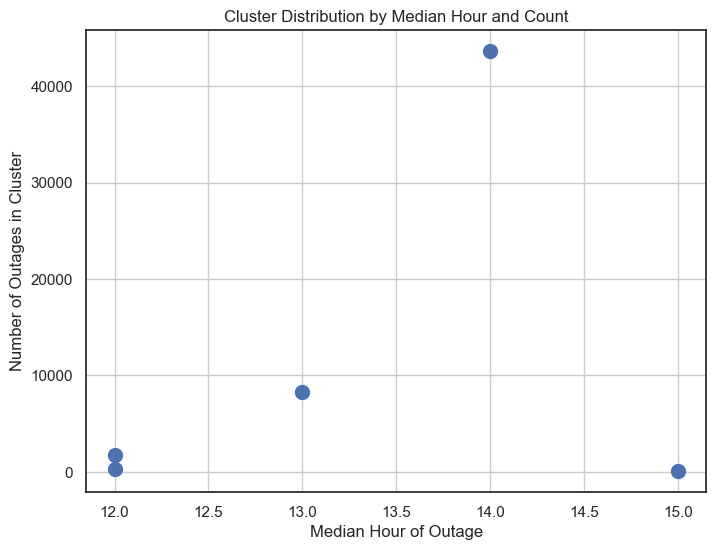

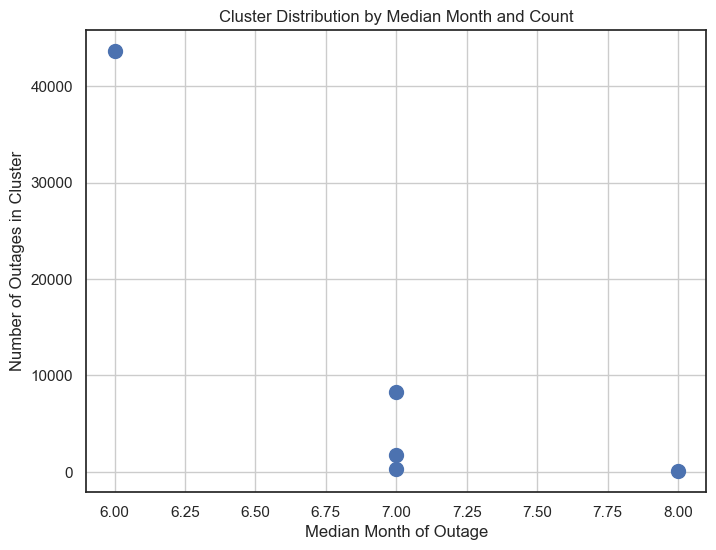

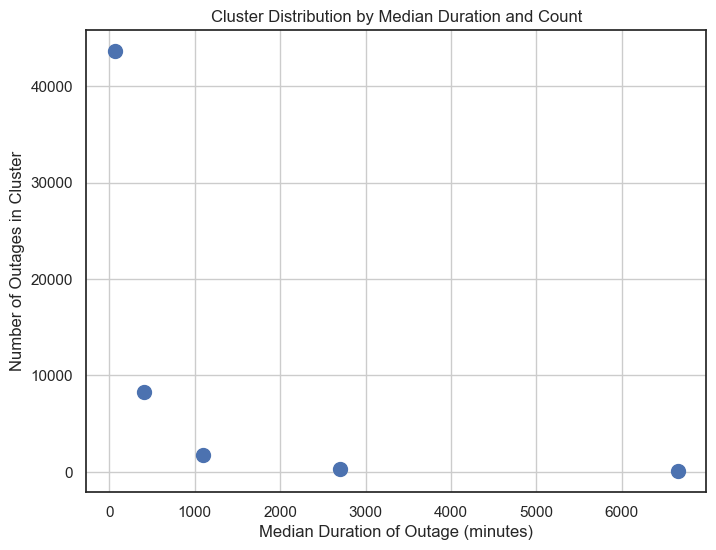

In [25]:
import matplotlib.pyplot as plt

# Assuming you have the 'cluster_stats' DataFrame available from your previous clustering

# 1. Scatter plot for Median Hour vs. Count
plt.figure(figsize=(8, 6))
plt.scatter(cluster_stats['hour']['median'], cluster_stats['hour']['count'], s=100)  # s controls marker size
plt.xlabel('Median Hour of Outage')
plt.ylabel('Number of Outages in Cluster')
plt.title('Cluster Distribution by Median Hour and Count')
plt.grid(True)
plt.show()

# 2. Scatter plot for Median Month vs. Count
plt.figure(figsize=(8, 6))
plt.scatter(cluster_stats['month']['median'], cluster_stats['month']['count'], s=100)
plt.xlabel('Median Month of Outage')
plt.ylabel('Number of Outages in Cluster')
plt.title('Cluster Distribution by Median Month and Count')
plt.grid(True)
plt.show()

# 3. Scatter plot for Median Duration vs. Count
plt.figure(figsize=(8, 6))
plt.scatter(cluster_stats['duration_minutes']['median'], cluster_stats['duration_minutes']['count'], s=100)
plt.xlabel('Median Duration of Outage (minutes)')
plt.ylabel('Number of Outages in Cluster')
plt.title('Cluster Distribution by Median Duration and Count')
plt.grid(True)
plt.show()

In [26]:
# Sort the cluster_stats DataFrame by the count of 'hour' in descending order
largest_clusters = cluster_stats.sort_values(('hour', 'count'), ascending=False)

# Select the top 10 rows (clusters)
top_10_clusters = largest_clusters.head(10)

# Display the top 10 clusters
print(top_10_clusters)

          hour               duration_minutes                month         \
          mean median  count             mean  median  count  mean median   
cluster                                                                     
0        13.13   14.0  43645            81.36    60.0  43645  6.52    6.0   
3        12.74   13.0   8260           445.29   405.0   8260  6.65    7.0   
2        11.79   12.0   1713          1176.63  1095.0   1713  6.80    7.0   
1        12.20   12.0    338          2937.69  2700.0    338  6.57    7.0   
4        13.84   15.0     70          7010.57  6660.0     70  7.57    8.0   

               percentage  
         count             
cluster                    
0        43645      80.79  
3         8260      15.29  
2         1713       3.17  
1          338       0.63  
4           70       0.13  


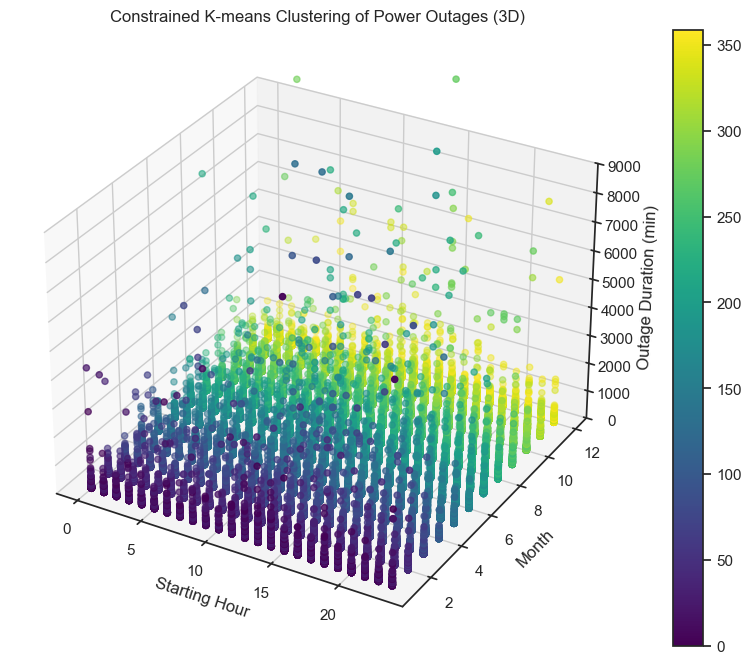

In [27]:
# Clustering by months
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# ... (previous code to create Massachusetts_starting_df) ...

# Separate data by month
monthly_data = {}
for month in Massachusetts_starting_df['month'].unique():
    monthly_data[month] = Massachusetts_starting_df[Massachusetts_starting_df['month'] == month][clustering_columns]

# Perform clustering for each month separately
for month, data in monthly_data.items():
    # Choose the number of clusters (k) for this month. You might want to adjust this based on the number of data points in each month.
    k_month = min(30, len(data))  # Example: at least 3 clusters, up to 10

    # Initialize the KMeans model
    kmeans = KMeans(n_clusters=k_month, random_state=42)

    # Fit the model to the data for this month
    kmeans.fit(data)

    # Assign cluster labels with an offset to avoid overlap between months
    Massachusetts_starting_df.loc[Massachusetts_starting_df['month'] == month, 'cluster'] = kmeans.labels_ + (month-1) * 30 

# 3D Visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors based on cluster labels
scatter = ax.scatter(X['hour'], X['month'], X['duration_minutes'], c=Massachusetts_starting_df['cluster'], cmap='viridis')

# Set labels and title
ax.set_zlim(0, 9000)
ax.set_xlabel('Starting Hour')
ax.set_ylabel('Month')
ax.set_zlabel('Outage Duration (min)')
ax.set_title('Constrained K-means Clustering of Power Outages (3D)')

# Add a colorbar
plt.colorbar(scatter)

# Show the plot
plt.show()

In [28]:
# ... (Your previous code for constrained clustering) ...

# Iterate through each month
for month in Massachusetts_starting_df['month'].unique():

    # Filter data for the current month
    month_data = Massachusetts_starting_df[Massachusetts_starting_df['month'] == month]

    # Group by 'cluster' and calculate statistics for this month
    cluster_stats_month = month_data.groupby('cluster')[['hour', 'duration_minutes']].agg(['mean', 'median', 'count'])

    # Calculate the total number of points for this month
    total_count_month = cluster_stats_month['hour']['count'].sum()

    # Calculate the percentage for each cluster within this month
    cluster_stats_month['percentage'] = ((cluster_stats_month['hour']['count'] / total_count_month) * 100).round(2)

    # Round the mean and median values to 2 decimal places
    cluster_stats_month = cluster_stats_month.round(2)

    # Display the cluster statistics for this month
    print(f"\nCluster Statistics for Month {month}:\n")
    print(cluster_stats_month)


Cluster Statistics for Month 1:

          hour              duration_minutes               percentage
          mean median count             mean  median count           
cluster                                                              
0        13.41   15.0   791            52.13    45.0   791      17.39
1        12.75   14.0     4          2666.25  2677.5     4       0.09
2        11.04   11.5    26          1012.50  1005.0    26       0.57
3        13.12   14.0    74           441.69   435.0    74       1.63
4        15.00   15.0     1          8640.00  8640.0     1       0.02
5        14.50   15.0   156           254.71   255.0   156       3.43
6         6.00    6.0     1          3915.00  3915.0     1       0.02
7         8.33    3.0     9          1368.33  1365.0     9       0.20
8        12.88   13.0    49           742.04   735.0    49       1.08
9        13.40   14.0   407           111.19   105.0   407       8.95
10        9.00    9.0     1          5460.00  5460.0    

## Probabilities

In [43]:
%%script false
# Define the bins for the outage duration categories
bins = [0, 61, 181, 361, 1441, float('inf')]  # float('inf') represents infinity for the last bin

# Create labels for the categories
labels = ['0-60min', '61-180min', '181-360min', '361-1440min', '>1440min']

# Create a new column 'duration_category' and categorize the 'duration_minutes'
Massachusetts_starting_df['duration_category'] = pd.cut(Massachusetts_starting_df['duration_minutes'], bins=bins, labels=labels, right=False)

Couldn't find program: 'false'


In [44]:
%%script false
import pandas as pd

def calculate_probability(df, months, hours, duration_categories):
  """
  Calculates the probability of a power outage with given characteristics.

  Args:
      df: The dataframe containing power outage data.
      months: A list of months to consider.
      hours: A list of hours to consider.
      duration_categories: A list of duration categories to consider.

  Returns:
      The probability of a power outage with the given characteristics.
  """

  filtered_df = df[(df['month'].isin(months)) & 
                   (df['hour'].isin(hours)) & 
                   (df['duration_category'].isin(duration_categories))]
  filtered_count = len(filtered_df)
  total_count = len(df)

  return filtered_count / total_count

# Calculate and print the probability with the new conditions
months = [2, 3, 4]
hours = [12, 17, 23]
duration_categories = ['61-180min']
probability = calculate_probability(Massachusetts_starting_df, months, hours, duration_categories)
print(f"The probability of a power outage in months {months}, at hours {hours}, with duration categories {duration_categories} is: {probability}")

Couldn't find program: 'false'


In [45]:
%%script false
import pandas as pd
import matplotlib.pyplot as plt

def plot_outage_duration_histogram(df, months, hours):
  """
  Plots a 2D graph with outage duration on the x-axis and the number of occurrences on the y-axis,
  filtered by specific months and hours.

  Args:
      df: The dataframe containing power outage data.
      months: A list of months to consider.
      hours: A list of hours to consider.
  """

  # Filter the dataframe based on months and hours
  filtered_df = df[(df['month'].isin(months)) & 
                   (df['hour'].isin(hours))]

  # Count the occurrences for each duration
  duration_counts = filtered_df['duration_minutes'].value_counts().sort_index()

  # DEBUG: Print the shape of the filtered dataframe
  print("Shape of filtered_df:", filtered_df.shape)

  # Count the occurrences for each duration
  duration_counts = filtered_df['duration_minutes'].value_counts().sort_index()

  # Create a DataFrame from the duration counts
  result_df = pd.DataFrame({'duration_minutes': duration_counts.index, 'count': duration_counts.values})

  # Create a unique name for the result DataFrame based on months and hours
  result_df_name = f"outage_duration_counts_months_{'_'.join(map(str, months))}_hours_{'_'.join(map(str, hours))}"

  # Store the result DataFrame in the global namespace
  globals()[result_df_name] = result_df


  # DEBUG: Print duration_counts
  print("duration_counts:", duration_counts)

  # Plot the histogram
  plt.plot(duration_counts.index, duration_counts.values)
  plt.xlabel('Duration of Outage (minutes)')
  plt.ylabel('Number of Occurrences')
  plt.title(f'Outage Duration Histogram for Months {months} at Hours {hours}')
  plt.show()


# Plot the histogram for the specified months and hours
months = [2,3,4,5]
hours = [12]
plot_outage_duration_histogram(Massachusetts_starting_df, months, hours)
outage_duration_counts_months_2_hours_12

Couldn't find program: 'false'


In [46]:
%%script false
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import poisson
import matplotlib.pyplot as plt
import altair as alt

# ... (your existing code defining county_names and plot_outage_duration_histogram) ...

# 1. Collect starting DataFrames, ensuring they exist
starting_dfs = [globals()[f"{county_name}_starting_df"] for county_name in county_names if f"{county_name}_starting_df" in globals()]

# 2. Check if there's any data to concatenate
if not starting_dfs:
    print("No data available for any county. Skipping analysis.")
else:
    # 3. Concatenate into Massachusetts_starting_df
    Massachusetts_starting_df = pd.concat(starting_dfs, ignore_index=True)

    # 4. Call the function and store the returned DataFrame
    months = [2]
    hours = [12]
    outage_duration_counts_months_2_hours_12 = plot_outage_duration_histogram(Massachusetts_starting_df, months, hours)

    # 5. Get the maximum duration
    max_duration = outage_duration_counts_months_2_hours_12['duration_minutes'].max()

    # 6. Create a new index with all multiples of 15
    full_index = pd.Index(range(0, max_duration + 1, 15), name='duration_minutes')

    # 7. Reindex and fill missing values
    complete_duration_counts = outage_duration_counts_months_2_hours_12.set_index('duration_minutes').reindex(full_index, fill_value=0).reset_index()

    # 8. Extract x_values and data
    x_values = complete_duration_counts['duration_minutes']
    data = complete_duration_counts['count']

    # 9. Define the Poisson function
    def poisson_func(k, lamb):
        '''poisson function, parameter lamb is the fit parameter'''
        k_intervals = k // 15  # Convert to 15-minute intervals
        return poisson.pmf(k_intervals, lamb)

    # 10. Fit with curve_fit
    params, cov_matrix = curve_fit(poisson_func, x_values, data)
    lambda_param = params[0]

    # 11. Create x_plot
    x_plot = np.arange(0, max_duration + 1, 15)

    # 12. Calculate fitted Poisson probabilities
    y_plot = [poisson_func(x, lambda_param) * len(data) for x in x_plot] 

    # 13-14. Create and display the plot using Altair
    # Prepare data for plotting
    # Use the original outage_duration_counts_months_2_hours_12 for observed data
    df_observed = outage_duration_counts_months_2_hours_12.rename(columns={'count': 'Number of Occurrences'})
    df_observed['type'] = 'Observed'
    df_fitted = pd.DataFrame({'duration_minutes': x_plot, 'Number of Occurrences': y_plot, 'type': 'Fitted Poisson'})
    df_combined = pd.concat([df_observed, df_fitted])

    # Create the chart
    chart = alt.Chart(df_combined).mark_point(filled=True).encode(
        x='duration_minutes:Q',
        y='Number of Occurrences:Q',
        color='type:N',
        tooltip=['duration_minutes', 'Number of Occurrences', 'type']
    ).properties(
        title='Outage Duration Histogram with Fitted Poisson'
    ).interactive()

    chart.save('outage_duration_histogram_with_poisson_fit.json')

Couldn't find program: 'false'


# Hospital demand

In [59]:
import csv

def display_csv_headers(filename):
    """
    Opens a CSV file and displays its column headers.

    Args:
        filename: The name of the CSV file to open.
    """

    try:
        with open(filename, 'r', newline='') as csvfile:
            reader = csv.reader(csvfile)
            headers = next(reader)  # Read the first row, which contains headers

            print("Column Headers:")
            for header in headers:
                print(header)

    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")

# Example usage:
filename = "C:/Users/jonas/OneDrive/Dokumente/EPFL École polytéchnique de Lausanne/Cours/MA4/MIT Master Thesis/Work/Power_Outages/hospital_demand_15min.csv"  # Replace with your actual CSV filename
display_csv_headers(filename)

Column Headers:
Timestamp (EST)
baseline.out.district_cooling.cooling.energy_consumption.kwh
baseline.out.district_heating.heating.energy_consumption.kwh
baseline.out.district_heating.water_systems.energy_consumption.kwh
baseline.out.electricity.cooling.energy_consumption.kwh
baseline.out.electricity.exterior_lighting.energy_consumption.kwh
baseline.out.electricity.fans.energy_consumption.kwh
baseline.out.electricity.heat_recovery.energy_consumption.kwh
baseline.out.electricity.heat_rejection.energy_consumption.kwh
baseline.out.electricity.heating.energy_consumption.kwh
baseline.out.electricity.interior_equipment.energy_consumption.kwh
baseline.out.electricity.interior_lighting.energy_consumption.kwh
baseline.out.electricity.pumps.energy_consumption.kwh
baseline.out.electricity.refrigeration.energy_consumption.kwh
baseline.out.electricity.water_systems.energy_consumption.kwh
baseline.out.natural_gas.heating.energy_consumption.kwh
baseline.out.natural_gas.interior_equipment.energy_consu

In [60]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("C:/Users/jonas/OneDrive/Dokumente/EPFL École polytéchnique de Lausanne/Cours/MA4/MIT Master Thesis/Work/Power_Outages/hospital_demand_15min.csv") 

# Select only the desired column
total_electricity_demand_hospital_massachusetts = df[['Timestamp (EST)','baseline.out.electricity.total.energy_consumption.kwh']]

total_electricity_demand_hospital_massachusetts = total_electricity_demand_hospital_massachusetts.rename(columns={'Timestamp (EST)':'timestamp', 'baseline.out.electricity.total.energy_consumption.kwh': 'hospital_demand_ma'})
# Assuming 'timestamp' is already in datetime format, remove timezone offset by converting to string and slicing
total_electricity_demand_hospital_massachusetts['timestamp'] = total_electricity_demand_hospital_massachusetts['timestamp'].astype(str).str[:-6]

# Display the first few rows of the new DataFrame
total_electricity_demand_hospital_massachusetts['hospital_demand_ma'].sum()


np.float64(942990008.5506254)

In [61]:
# scaling to a typical hospital: https://electricityplans.com/landing/electricity-for-hospitals-clinics-medical-offices/
average_hospital_size = 247000 #square feet
average_demand_per_sq_ft = 31 # kWh/sq ft
yearly_hospital_demand = average_hospital_size * average_demand_per_sq_ft

scaling_factor = yearly_hospital_demand/ total_electricity_demand_hospital_massachusetts['hospital_demand_ma'].sum()

electricity_demand_typical_hospital_ma = total_electricity_demand_hospital_massachusetts[['timestamp']].copy() 
electricity_demand_typical_hospital_ma['hospital_demand_ma'] = total_electricity_demand_hospital_massachusetts['hospital_demand_ma'] * scaling_factor *4 # Watch out! Everything is in kW now!!
electricity_demand_typical_hospital_ma.head()
print(f'Number of hospitals {1/scaling_factor}')

electricity_demand_typical_hospital_ma['hospital_demand_ma'].mean()


Number of hospitals 123.15397787000462


np.float64(874.0867579908676)

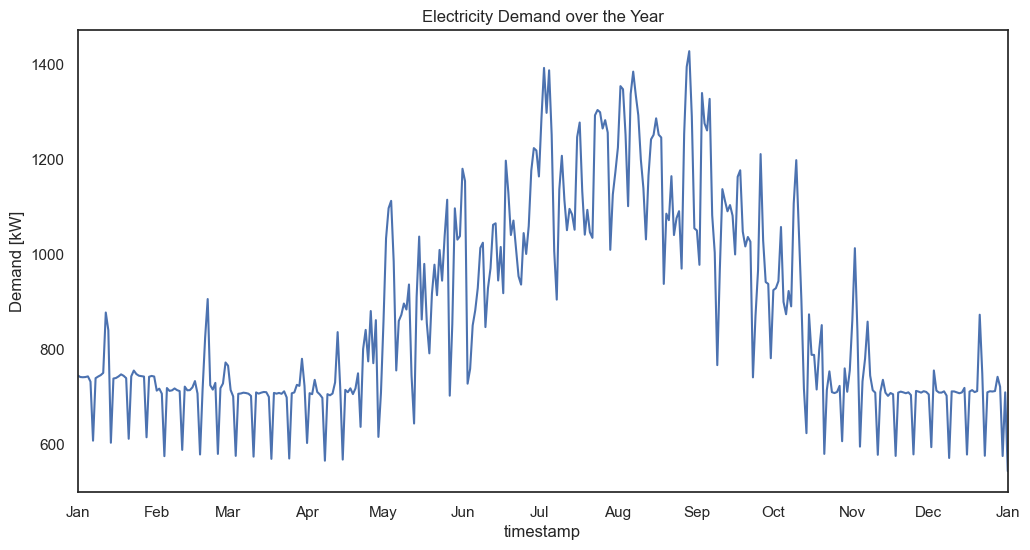

C:\Users\jonas\AppData\Local\Temp\ipykernel_25516\3513813405.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  electricity_demand_typical_hospital_ma['hospital_demand_ma'].resample('M').mean().plot()


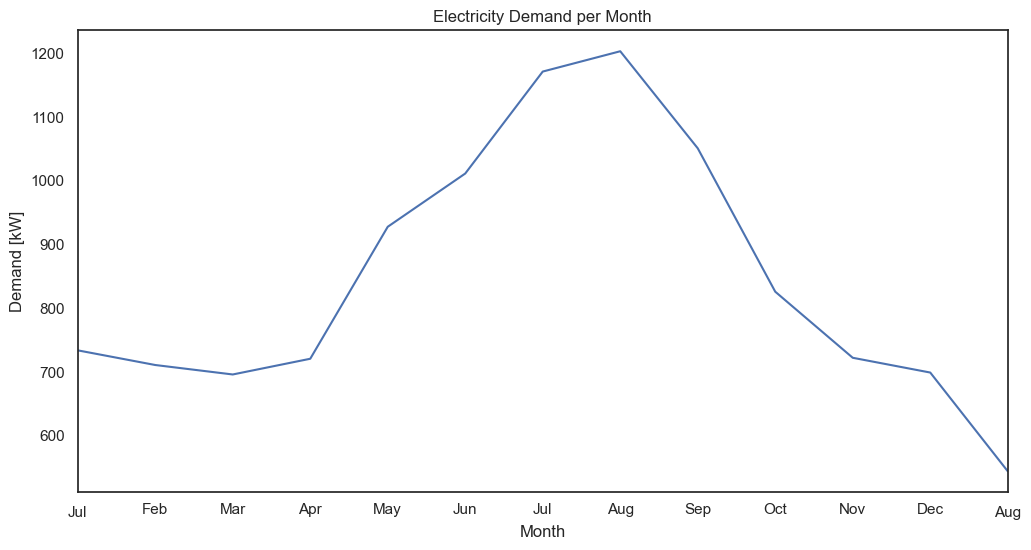

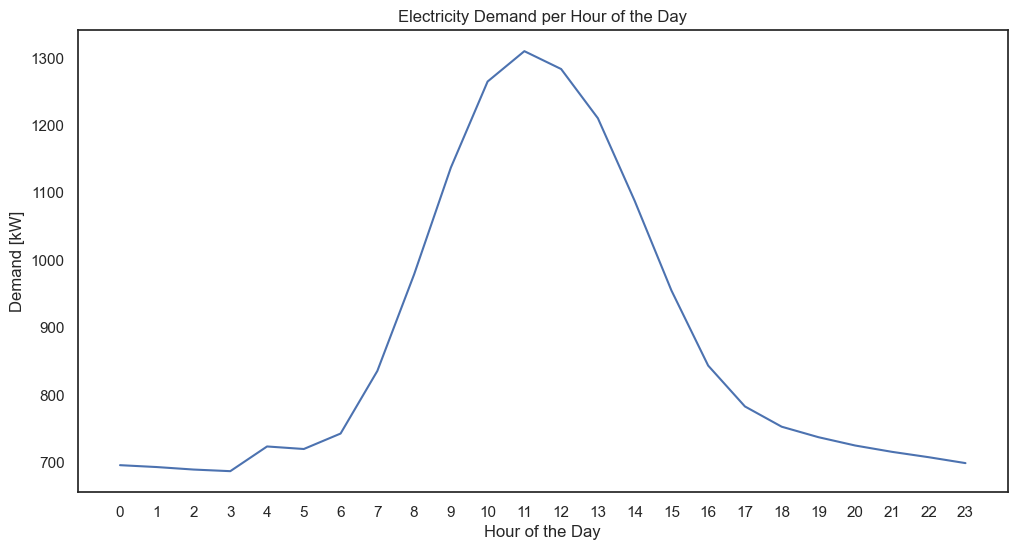

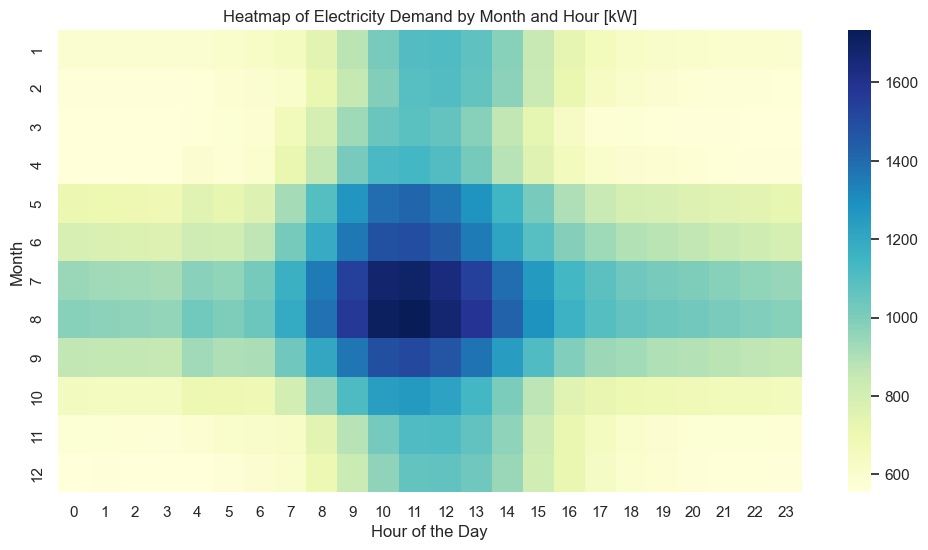

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Assuming your DataFrame is already loaded and named 'total_electricity_demand_hospital_massachusetts'

# Convert the 'timestamp' column to datetime if it's not already in datetime format
electricity_demand_typical_hospital_ma['timestamp'] = pd.to_datetime(electricity_demand_typical_hospital_ma['timestamp'])

# Set the 'timestamp' column as the index for easier time-based operations
electricity_demand_typical_hospital_ma.set_index('timestamp', inplace=True)

# 1. Demand Over the Year
plt.figure(figsize=(12, 6))
electricity_demand_typical_hospital_ma['hospital_demand_ma'].resample('D').mean().plot()
# Format x-axis ticks to show only month
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) 
plt.title('Electricity Demand over the Year')
plt.ylabel('Demand [kW]')
plt.show()

# 2. Demand Per Month
plt.figure(figsize=(12, 6))
electricity_demand_typical_hospital_ma['hospital_demand_ma'].resample('M').mean().plot()
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) 
plt.title('Electricity Demand per Month')
plt.xlabel('Month')
plt.ylabel('Demand [kW]')
plt.show()

# 3. Demand Per Hour of the Day
plt.figure(figsize=(12, 6))
electricity_demand_typical_hospital_ma['hospital_demand_ma'].groupby(electricity_demand_typical_hospital_ma.index.hour).mean().plot()
plt.title('Electricity Demand per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.xticks(range(24))
plt.ylabel('Demand [kW]')
plt.show()

# 4. Heatmap with Month as x-axis, Hour of the Day as y-axis, and Colorscheme According to Demand
# Prepare data for the heatmap
heatmap_data = electricity_demand_typical_hospital_ma['hospital_demand_ma'].groupby([electricity_demand_typical_hospital_ma.index.month, electricity_demand_typical_hospital_ma.index.hour]).mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title('Heatmap of Electricity Demand by Month and Hour [kW]')
plt.xlabel('Hour of the Day')
plt.ylabel('Month')
plt.show()

In [63]:
## Heating demand

import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("C:/Users/jonas/OneDrive/Dokumente/EPFL École polytéchnique de Lausanne/Cours/MA4/MIT Master Thesis/Work/Power_Outages/hospital_demand_15min.csv") 

# Select only the desired column
total_ng_heating_demand_hospital_massachusetts = df[['Timestamp (EST)','baseline.out.natural_gas.heating.energy_consumption.kwh']]

total_ng_heating_demand_hospital_massachusetts = total_ng_heating_demand_hospital_massachusetts.rename(columns={'Timestamp (EST)':'timestamp', 'baseline.out.natural_gas.heating.energy_consumption.kwh': 'hospital_demand_ma'})
# Assuming 'timestamp' is already in datetime format, remove timezone offset by converting to string and slicing
total_ng_heating_demand_hospital_massachusetts['timestamp'] = total_ng_heating_demand_hospital_massachusetts['timestamp'].astype(str).str[:-6]

# Display the first few rows of the new DataFrame
total_ng_heating_demand_hospital_massachusetts['hospital_demand_ma'].sum()

np.float64(497724900.11037177)

In [64]:
# scaling to a typical hospital: https://electricityplans.com/landing/electricity-for-hospitals-clinics-medical-offices/
#take same scaling factor (of course)

ng_heating_demand_typical_hospital_ma = total_ng_heating_demand_hospital_massachusetts[['timestamp']].copy() 
ng_heating_demand_typical_hospital_ma['hospital_demand_ma'] = total_ng_heating_demand_hospital_massachusetts['hospital_demand_ma'] * scaling_factor *4 # Watch out! Everything is in kW now!!
ng_heating_demand_typical_hospital_ma.head()
print(f'Number of hospitals {1/scaling_factor}')
ng_heating_demand_typical_hospital_ma['hospital_demand_ma'].mean()

Number of hospitals 123.15397787000462


np.float64(461.3566849743)

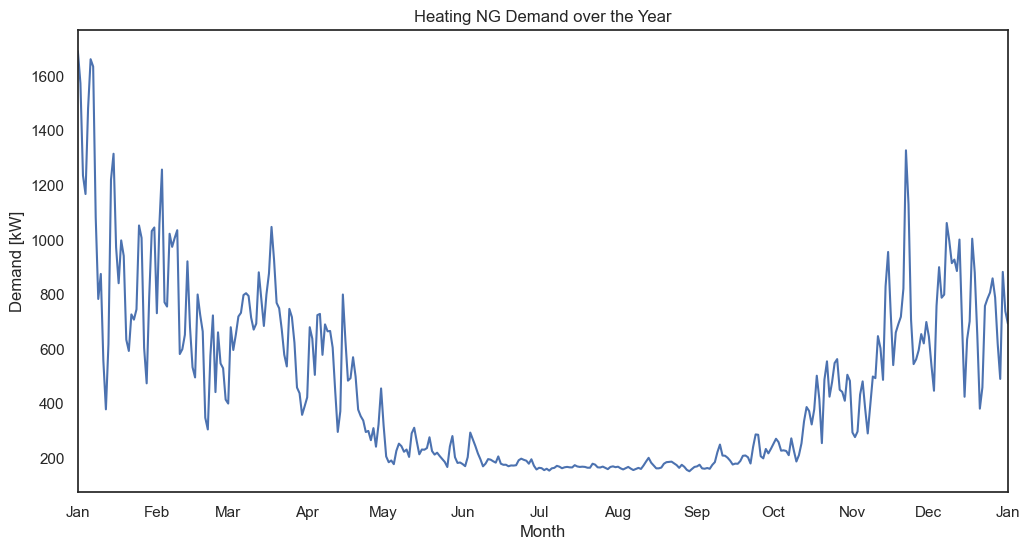

C:\Users\jonas\AppData\Local\Temp\ipykernel_25516\3595108283.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ng_heating_demand_typical_hospital_ma['hospital_demand_ma'].resample('M').mean().plot()


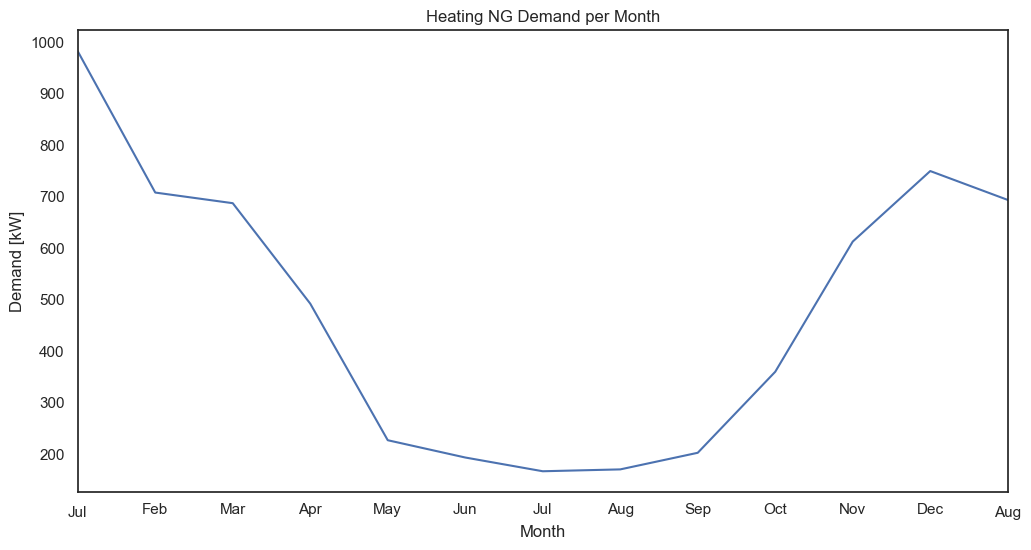

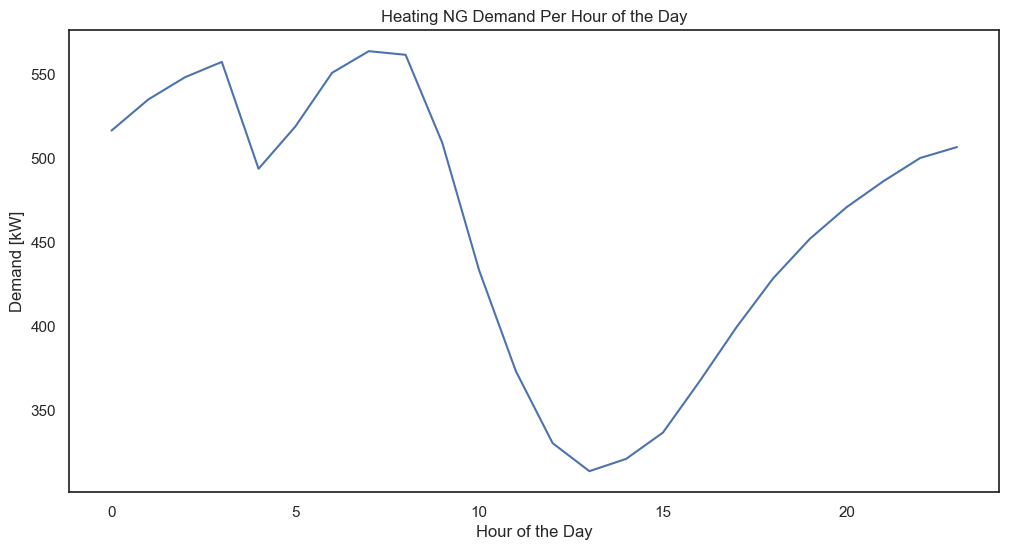

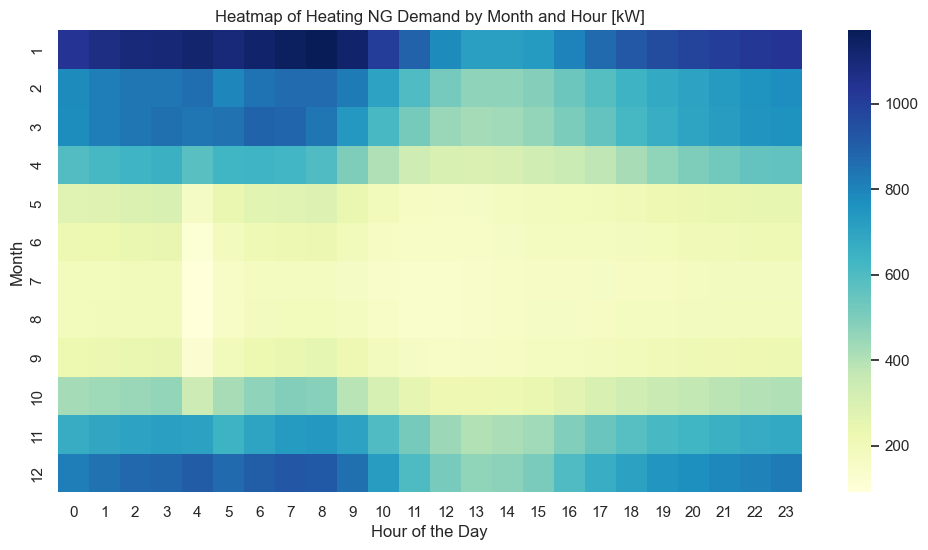

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is already loaded and named 'total_electricity_demand_hospital_massachusetts'

# Convert the 'timestamp' column to datetime if it's not already in datetime format
ng_heating_demand_typical_hospital_ma['timestamp'] = pd.to_datetime(ng_heating_demand_typical_hospital_ma['timestamp'])

# Set the 'timestamp' column as the index for easier time-based operations
ng_heating_demand_typical_hospital_ma.set_index('timestamp', inplace=True)

# 1. Demand Over the Year
plt.figure(figsize=(12, 6))
ng_heating_demand_typical_hospital_ma['hospital_demand_ma'].resample('D').mean().plot()
plt.title('Heating NG Demand over the Year')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel('Month')
plt.ylabel('Demand [kW]')
plt.show()

# 2. Demand Per Month
plt.figure(figsize=(12, 6))
ng_heating_demand_typical_hospital_ma['hospital_demand_ma'].resample('M').mean().plot()
plt.title('Heating NG Demand per Month')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel('Month')
plt.ylabel('Demand [kW]')
plt.show()

# 3. Demand Per Hour of the Day
plt.figure(figsize=(12, 6))
ng_heating_demand_typical_hospital_ma['hospital_demand_ma'].groupby(ng_heating_demand_typical_hospital_ma.index.hour).mean().plot()
plt.title('Heating NG Demand Per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Demand [kW]')
plt.show()

# 4. Heatmap with Month as x-axis, Hour of the Day as y-axis, and Colorscheme According to Demand
# Prepare data for the heatmap
heatmap_data = ng_heating_demand_typical_hospital_ma['hospital_demand_ma'].groupby([ng_heating_demand_typical_hospital_ma.index.month, ng_heating_demand_typical_hospital_ma.index.hour]).mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title('Heatmap of Heating NG Demand by Month and Hour [kW]')
plt.xlabel('Hour of the Day')
plt.ylabel('Month')
plt.show()

In [87]:
# slicing the demand data
import random

# List to store sliced DataFrames
sliced_demand_data = []

# Iterate over each cluster in rounded_cluster_stats
for _, row in rounded_cluster_stats.iterrows():
    cluster = row['cluster']
    start_hour = int(row['hour'])
    duration_minutes = int(row['duration_minutes'])
    month = int(row['month'])

    # Filter demand data for the given month
    month_data = electricity_demand_typical_hospital_ma[electricity_demand_typical_hospital_ma.index.month == month]

    # Get all days in the month and randomly select one
    days_in_month = month_data.index.day.unique()
    random_day = random.choice(days_in_month)

    # Filter further for the specific day and hour
    start_time = pd.Timestamp(year=month_data.index[0].year, month=month, day=random_day, hour=start_hour)
    end_time = start_time + pd.Timedelta(minutes=duration_minutes-15)
    sliced_data = month_data.loc[start_time:end_time].copy() 

    # Add 'cluster' column to identify the slice
    sliced_data['cluster'] = cluster

    # Append to the list
    sliced_demand_data.append(sliced_data)

# Concatenate all sliced DataFrames into one
final_demand_data = pd.concat(sliced_demand_data)

# Display the final DataFrame
print(final_demand_data)
electricity_demand_typical_hospital_ma.max()

                     hospital_demand_ma  cluster
timestamp                                       
2018-06-02 16:00:00         1116.042351      0.0
2018-06-02 16:15:00         1107.244694      0.0
2018-06-02 16:30:00         1100.996170      0.0
2018-06-02 16:45:00         1082.640791      0.0
2018-06-02 17:00:00         1082.540655      0.0
...                                 ...      ...
2018-07-04 05:15:00         1059.682593     99.0
2018-07-04 05:30:00         1029.770596     99.0
2018-07-04 05:45:00         1044.666926     99.0
2018-07-04 06:00:00         1049.916185     99.0
2018-07-04 06:15:00         1089.857670     99.0

[39687 rows x 2 columns]


hospital_demand_ma    2194.537267
dtype: float64

In [88]:
import random

# List to store sliced DataFrames
sliced_demand_data = []

# Total desired rows in the final DataFrame
total_rows = len(rounded_cluster_stats) * 500

# Iterate over each cluster in rounded_cluster_stats
for _, row in rounded_cluster_stats.iterrows():
    cluster = row['cluster']
    start_hour = int(row['hour'])
    duration_minutes = int(row['duration_minutes'])
    month = int(row['month'])

    # Filter demand data for the given month
    month_data = electricity_demand_typical_hospital_ma[electricity_demand_typical_hospital_ma.index.month == month]

    # Get all days in the month and randomly select one
    days_in_month = month_data.index.day.unique()
    random_day = random.choice(days_in_month)

    # Filter further for the specific day and hour
    start_time = pd.Timestamp(year=month_data.index[0].year, month=month, day=random_day, hour=start_hour)
    end_time = start_time + pd.Timedelta(minutes=duration_minutes - 15)
    sliced_data = month_data.loc[start_time:end_time].copy()

    # Add 'cluster' column to identify the slice
    sliced_data['cluster'] = cluster

    # Pad with zeros to reach 500 rows for this cluster
    rows_to_add = 500 - len(sliced_data)
    if rows_to_add > 0:
        padding_data = pd.DataFrame(0, index=range(rows_to_add), columns=sliced_data.columns)
        sliced_data = pd.concat([sliced_data, padding_data])

    # Append to the list
    sliced_demand_data.append(sliced_data)

# Concatenate all sliced DataFrames into one
final_demand_data = pd.concat(sliced_demand_data)

# Ensure the final DataFrame has the exact desired number of rows
if len(final_demand_data) > total_rows:
    final_demand_data = final_demand_data.iloc[:total_rows]
elif len(final_demand_data) < total_rows:
    padding_data = pd.DataFrame(0, index=range(total_rows - len(final_demand_data)), columns=final_demand_data.columns)
    final_demand_data = pd.concat([final_demand_data, padding_data])

# Rename the column and divide values by 1000
final_demand_data.rename(columns={'hospital_demand_ma': 'Demand_MW_z1'}, inplace=True)
final_demand_data['Demand_MW_z1'] = final_demand_data['Demand_MW_z1'] / 1000

# Add 500 additional zeros at the end
additional_zeros = pd.DataFrame(0, index=range(500), columns=final_demand_data.columns)
final_demand_data = pd.concat([final_demand_data, additional_zeros])

# Display the final DataFrame
print(final_demand_data)

                     Demand_MW_z1  cluster
2018-06-06 16:00:00      0.937209      0.0
2018-06-06 16:15:00      0.924946      0.0
2018-06-06 16:30:00      0.898315      0.0
2018-06-06 16:45:00      0.885187      0.0
2018-06-06 17:00:00      0.887951      0.0
...                           ...      ...
495                      0.000000      0.0
496                      0.000000      0.0
497                      0.000000      0.0
498                      0.000000      0.0
499                      0.000000      0.0

[50500 rows x 2 columns]


In [89]:
import pandas as pd

# ... (your existing code for creating final_demand_data and rounded_cluster_stats) ...

# Create a separate DataFrame for the single-row columns (Adapt values as needed)
overall_outage_probability = 0.000634
summary_df = pd.DataFrame({
    'Voll': [500000],  # Replace with appropriate value
    'Demand_Segment': [1],  # Replace with appropriate value
    'Cost_of_Demand_Curtailment_per_MW': [1],  # Replace with appropriate value
    'Max_Demand_Curtailment': [1],  # Replace with appropriate value
    '$/MWh': [20000],  # Replace with appropriate value
    'Rep_Periods': [len(rounded_cluster_stats) + 1],  # Number of clusters + 1
    'Timesteps_per_Rep_Period': [500],  # Fixed value
})

# Create a DataFrame for Sub_Weights, multiplying each probability by 35040
# Add the new weight for the additional period
sub_weights = (rounded_cluster_stats['percentage'] / 100 * 500 * len(rounded_cluster_stats)* overall_outage_probability).tolist()
sub_weights.append((1-overall_outage_probability) * 500 * len(rounded_cluster_stats)) 
sub_weights_df = pd.DataFrame({'Sub_Weights': sub_weights})

# Prepare the final_demand_data for concatenation
# Reset the index to ensure proper alignment during concatenation
final_demand_data_reset = final_demand_data.reset_index(drop=True)

# Drop the 'cluster' column
final_demand_data_reset = final_demand_data_reset.drop(columns=['cluster'])

# Create the Time_Index column
total_rows = (len(rounded_cluster_stats) + 1) * 500
time_index_df = pd.DataFrame({'Time_Index': range(1, total_rows + 1)})

# Concatenate all DataFrames horizontally, including the new Time_Index column
final_df = pd.concat([summary_df, sub_weights_df, time_index_df, final_demand_data_reset], axis=1)

# Save to Excel
final_df.to_csv('final_demand_data.csv', index=False)

print("Demand profile generated and saved to 'final_demand_data.csv'")

Demand profile generated and saved to 'final_demand_data.csv'


In [69]:
# Print the header names
print(final_df.columns.tolist())


['Voll', 'Demand_Segment', 'Cost_of_Demand_Curtailment_per_MW', 'Max_Demand_Curtailment', '$/MWh', 'Rep_Periods', 'Timesteps_per_Rep_Period', 'Sub_Weights', 'Time_Index', 'Demand_MW_z1']
